# How to put your measurements into the meso-scale context of cloud patterns

The meso-scale patterns of shallow convection as described by {cite}`Stevens:2021` 
are a great way to learn more about the meso-scale variability in cloudiness in the
trades. Four meso-scale cloud patterns have been identified to frequently reoccur.
These four patterns that are shown in the figure below are named based on their
visual impressions: Sugar, Gravel, Flowers and Fish.

```{figure} c3ontext_cloud_patterns.jpg
:alt: Meso-scale cloud patterns
:width: 400px
:align: center

Four meso-scale cloud patterns have been identified to be reoccuring in the trades. They are
named based on their visual impressions: Sugar, Gravel, Flowers, Fish. Satellite image source: NASA Worldview.
```

Both rule-based algorithms and deep neural networks have been developed to identify these
patterns automatically to learn more about their characteristics and processes.
For the time period of the EUREC<sup>4</sup>A campaign, a group of 50 participants
has identified these meso-scale patterns manually on satellite images. Their classifications build
the *Common Consensus on Convective OrgaNizaTionduring the EUREC4A eXperimenT* dataset, short
**C<sup>3</sup>ONTEXT**.

As the acronym already suggests, the dataset is meant to provide the meso-scale *context* to additional
observations. The following example shows how this meso-scale context, the information about the most
dominant cloud patterns, can be retrieved along a platform track. In this particular example, it is
the track of the R/V Meteor. The measurements made onboard the research vessel like cloud radar and Raman
lidar can therefor be analysed and interpreted with respect to the four cloud patterns.

More details on this dataset can be found in {cite}`Schulz:2022` and
in the [C<sup>3</sup>ONTEXT GitHub-repository](https://github.com/observingClouds/EUREC4A_manualclassifications).

## Accessing the data

In [1]:
import numpy as np
import datetime as dt
import dask
import matplotlib.pyplot as plt
import eurec4a
from matplotlib import dates
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
plt.style.use(["./mplstyle/book", "./mplstyle/wide"])

cat = eurec4a.get_intake_catalog(use_ipfs="QmahMN2wgPauHYkkiTGoG2TpPBmj3p5FoYJAq9uE9iXT9N")

The *C<sup>3</sup>ONTEXT* dataset consists of various processing levels. In the intake catalog the level-2 and level-3 data
are registered, which should be sufficient for most applications. These datasets consist of spatial-temporal referenced
classification masks for all available workflows such that queries are rather simple.

In [2]:
c3ontext_cat = cat.c3ontext
list(c3ontext_cat)

['level2',
 'level3_ICON-albedo_daily',
 'level3_ICON-albedo_instant',
 'level3_IR_daily',
 'level3_IR_instant',
 'level3_VIS_daily',
 'level3_VIS_instant']

````{admonition} Overview about processing levels

| Level | Description |
|:---:|---|
| 0 | Raw dataset as CSV file. No geo-referenced data, just plain labels in pixel coordinates. Includes house-keeping files. Use this dataset for analyzing the technical aspects of labels, e.g. how long did it take a person to draw a particular label. |
| 1 | Georeferenced dataset. Only base points of the labels are given, e.g. lat0, lon0, lat1, lon1. Use this dataset for developing your own ideas where no filled masks ( see next levels ) are needed. |
| 2 | Like level 1, but with labels being converted to masks. This dataset is easier to query if a particular position has been classified with a particular pattern or not. |
| 3 | This processing level contains the information on how often a pattern has been classified at a specific point in time and space for each workflow (IR, VIS, ICON). To retrieve these frequencies, the level 2 data has been resampled to individual (`instant`) and daily (`daily`) composites. The `instant` dataset can be used for studies of the diurnal cycle or for analyses where the sub-daily temporal evolution is of importance. The `daily` composite give a good overview about the daily situation. It should be noted though that in case of the `daily` composite, overlapping labels of one pattern from one particular person are only counted once towards the frequency. If one person has classified for example Flowers several times a day at the same location, it is only counted once towards the frequency to reduce the bias towards the perception of a single participant. |
```{figure} c3ontext_process_levels.png
:alt: Processing levels
:width: 600px
:align: center
```
````

## Contextualizing your data

By providing time and location of interest, the dominant patterns can be retrieved. Here, we use the manual classifications
that have been made based on infrared images. A benefit of these classifications is that they are covering the complete
diurnal cycle. The classifications of the visible workflow miss the night-time meso-scale variability.

In [3]:
ds = c3ontext_cat.level3_IR_daily.to_dask()
ds

<xarray.Dataset>
Dimensions:    (date: 47, longitude: 2200, latitude: 1500, pattern: 5)
Coordinates:
  * date       (date) datetime64[ns] 2020-01-07 2020-01-08 ... 2020-02-22
  * latitude   (latitude) float64 20.0 19.99 19.98 19.97 ... 5.03 5.02 5.01 5.0
  * longitude  (longitude) float64 -62.0 -61.99 -61.98 ... -40.02 -40.01 -40.0
  * pattern    (pattern) object 'Sugar' 'Flowers' 'Fish' 'Gravel' 'Unclassified'
Data variables:
    freq       (date, longitude, latitude, pattern) float64 dask.array<chunksize=(1, 2200, 1500, 5), meta=np.ndarray>
    nb_users   (date) float64 dask.array<chunksize=(47,), meta=np.ndarray>
Attributes:
    author:          Hauke Schulz (hauke.schulz@mpimet.mpg.de)
    created_on:      2022-02-06 12:26 UTC
    created_with:    create_level3.py with its last modification on Sun Feb  ...
    description:     Level-3: daily classification frequency
    doi:             10.5281/zenodo.5979718
    institute:       Max Planck Institut für Meteorologie, Germany
    python_version:  3.8.6 | packaged by conda-forge | (default, Nov 27 2020,...
    title:           EUREC4A: manual meso-scale cloud pattern classifications
    version:         v0.4.0

To get the classifications along a trajectory, we can make further use of the platform tracks indexed in the EUREC<sup>4</sup>A
Intake catalog. In the following, we show an example based on the track of the R/V Meteor.

In [4]:
platform = 'Meteor'
ds_plat = cat[platform].track.to_dask()

To simplify the visualization and queries, we calculate the daily average position. Note that this is just an approximation
and will fail when the track crosses the 0 meridian.

In [5]:
ds_plat_rs = ds_plat.resample(time='1D').mean()

Finally, we can load the data and plot the timeseries of classifications along the trajectory.

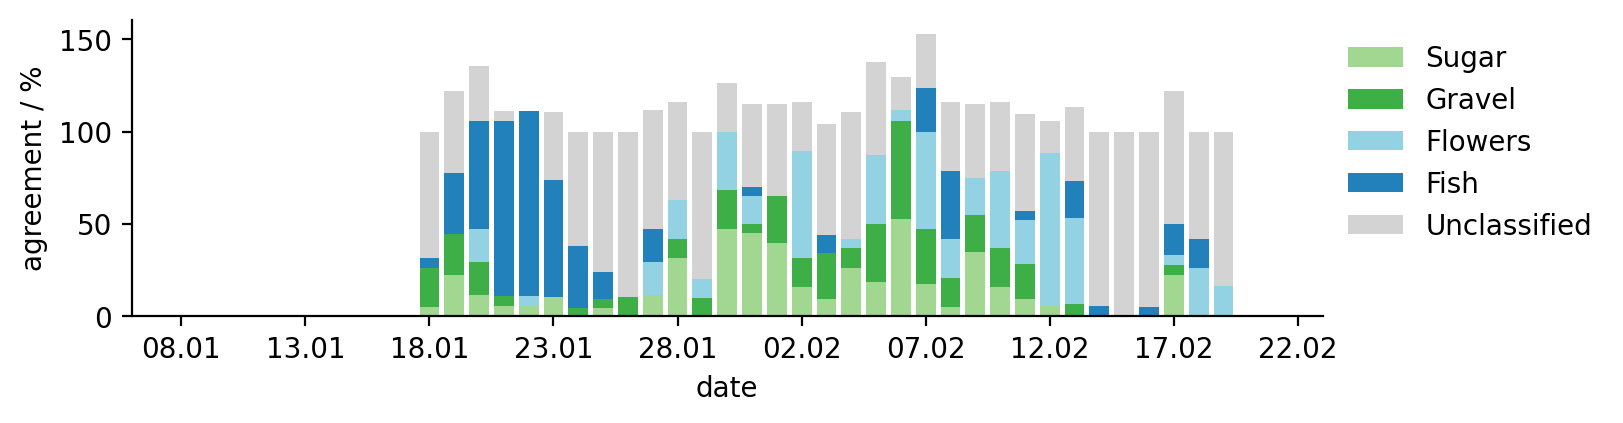

In [6]:
# Colors typical used for patterns
color_dict = {'Fish':'#2281BB',
              'Flowers': '#93D2E2',
              'Gravel': '#3EAE47',
              'Sugar': '#A1D791',
              'Unclassified' : 'lightgrey'
             }

# Reading the actual data
with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    data = ds.freq.interp(latitude=ds_plat_rs.lat, longitude=ds_plat_rs.lon).sel(date=ds_plat_rs.time)
    data.load()
data=data.fillna(0)*100

# Plotting
fig, ax = plt.subplots(figsize=(8,2))
for d, (time, tdata) in enumerate(data.groupby('time')):
    frequency = 0
    for p in ['Sugar', 'Gravel', 'Flowers', 'Fish', 'Unclassified']:
        ax.bar(dates.date2num(time), float(tdata.sel(pattern=p)), label=p, bottom=frequency, color=color_dict[p])
        hfmt = dates.DateFormatter('%d.%m')
        ax.xaxis.set_major_locator(dates.DayLocator(interval=5))
        ax.xaxis.set_major_formatter(hfmt)
        frequency += tdata.sel(pattern=p)
    if d == 0:
        plt.legend(frameon=False, bbox_to_anchor=(1,1))
plt.xlabel('date')
plt.ylabel('agreement / %')
xlim=plt.xlim(dt.datetime(2020,1,6), dt.datetime(2020,2,23))

This figure shows how many participants agreed on a specific pattern on a given date at a given location.

```{note}
Participants could attribute a given location to different patterns, causing some overlap. This overlap
is causing the stacked bar plots to exceed 100%.
```